# Brain Tumor Classifier

In [3]:
import cv2 
import tensorflow as tf
from tensorflow.python import keras
import numpy as np
import matplotlib.pyplot as plt
from kaggle.api.kaggle_api_extended import KaggleApi

import os
import glob
import random

In [4]:
os.environ['KAGGLE_USERNAME'] = "xxxxxx"                 #Manually input from kaggle
os.environ['KAGGLE_KEY'] = "xxxxxxx"   #Manually input from kaggle

api = KaggleApi()
api.authenticate()


api.dataset_download_files('masoudnickparvar/brain-tumor-mri-dataset', path="./Images/", unzip=True)

In [5]:
paths = ["Images/Testing/", "Images/Training/"]
types_of_tumors = os.listdir(paths[0])

In [6]:
data = []

for i,path in enumerate(paths):
    for label_int, label_str in enumerate(types_of_tumors):
        for filename in glob.glob(path + label_str + '/*.jpg'):
            img = cv2.imread(filename)
            data.append([label_int, cv2.resize(img,(280,280)) ])
print("Number of elements: {}".format(len(data)))

Number of elements: 7023


#### Division of the dataset into Training(80%), Validation(10%) and Testing(10%)

In [7]:
X_train , Y_train = [],[]
X_val , Y_val = [],[]
X_test , Y_test = [],[]

#Shuffle the data list everytime with the same seed
random.Random(0).shuffle(data)

for i, sample in enumerate(data):
    label, img = sample
    
    if i <= 0.8*len(data):
        X_train.append(img)
        Y_train.append(label)
    elif i > 0.8*len(data) and i < 0.9*len(data):
        X_val.append(img)
        Y_val.append(label)
    else:
        X_test.append(img)
        Y_test.append(label)


X_train = np.array(X_train)
X_val = np.array(X_train)
X_test = np.array(X_train)

Y_train = np.array(Y_train)
Y_val = np.array(Y_train)
Y_test = np.array(Y_train)

del data

#### OneHot encoding

In [8]:
Y_train_onehot = tf.one_hot(Y_train, len(types_of_tumors))
Y_val_onehot = tf.one_hot(Y_val, len(types_of_tumors))
Y_test_onehot = tf.one_hot(Y_test, len(types_of_tumors))

#### CNN Implementation

In [9]:
from keras.models import Sequential
from keras.layers import Convolution2D, Flatten, MaxPooling2D, Dense
from keras.optimizers import Adam

In [10]:
model = Sequential([
   Convolution2D(32, (3,3), input_shape=(280,280,3), activation = 'relu'),
   MaxPooling2D(pool_size=(2,2)),
   Flatten(),
   Dense(30, activation='relu'),
   Dense(4, activation='softmax')
])

model.compile(optimizer="ADAMAX", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 278, 278, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 139, 139, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 618272)            0         
                                                                 
 dense (Dense)               (None, 30)                18548190  
                                                                 
 dense_1 (Dense)             (None, 4)                 124       
                                                                 
Total params: 18,549,210
Trainable params: 18,549,210
Non-trainable params: 0
____________________________________________

In [11]:
from keras.callbacks import TensorBoard, ModelCheckpoint

chekpoint = ModelCheckpoint('Check_point/model.{epoch:d}.h5', save_best_only=False, save_freq='epoch')
tensorboard_cbck = TensorBoard('Logs/cnn_logs', histogram_freq=1)

In [12]:
#Train model
epoch = 20

model.fit(X_train, Y_train_onehot,epochs=epoch,batch_size=100,
            validation_data=[X_val, Y_val_onehot], callbacks=[tensorboard_cbck,chekpoint],  verbose=2)

Epoch 1/20
57/57 - 19s - loss: 420.5852 - accuracy: 0.5385 - val_loss: 11.6674 - val_accuracy: 0.7403 - 19s/epoch - 337ms/step
Epoch 2/20
57/57 - 13s - loss: 4.9888 - accuracy: 0.8338 - val_loss: 1.7898 - val_accuracy: 0.9096 - 13s/epoch - 236ms/step
Epoch 3/20
57/57 - 11s - loss: 1.3699 - accuracy: 0.9210 - val_loss: 0.7489 - val_accuracy: 0.9400 - 11s/epoch - 197ms/step
Epoch 4/20
57/57 - 11s - loss: 0.5506 - accuracy: 0.9541 - val_loss: 0.2160 - val_accuracy: 0.9749 - 11s/epoch - 187ms/step
Epoch 5/20
57/57 - 10s - loss: 0.2121 - accuracy: 0.9758 - val_loss: 0.0866 - val_accuracy: 0.9893 - 10s/epoch - 183ms/step
Epoch 6/20
57/57 - 9s - loss: 0.0765 - accuracy: 0.9923 - val_loss: 0.0468 - val_accuracy: 0.9950 - 9s/epoch - 166ms/step
Epoch 7/20
57/57 - 10s - loss: 0.0326 - accuracy: 0.9941 - val_loss: 0.0099 - val_accuracy: 0.9988 - 10s/epoch - 168ms/step
Epoch 8/20
57/57 - 9s - loss: 0.0085 - accuracy: 0.9991 - val_loss: 0.0044 - val_accuracy: 0.9993 - 9s/epoch - 162ms/step
Epoch 9/2

In [13]:
model.evaluate(X_test, Y_test_onehot)

176/176 [==============================] - 1s 7ms/step - loss: 5.0514e-05 - accuracy: 1.0000


[5.051443076808937e-05, 1.0]

##### Tensorboard for choosing the best model

In [16]:
%load_ext tensorboard
%tensorboard --logdir ./Logs/ 

Reusing TensorBoard on port 6006 (pid 4128), started 1 day, 12:04:01 ago. (Use '!kill 4128' to kill it.)

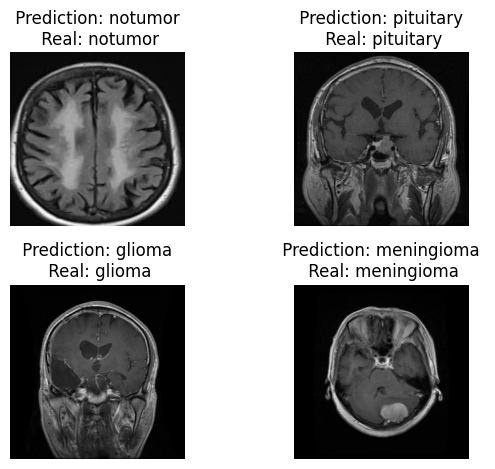

In [20]:
fig, axs = plt.subplots(2, 2)

for i in range(2):
    for j in range(2):
        rand_img = random.randint(0,X_test.shape[0])
        predict = model.predict(np.array([X_test[rand_img]]), verbose=0)
        predict = np.argmax(predict)

        axs[i][j].imshow(X_test[rand_img])
        axs[i][j].set_title(" Prediction: {} \n Real: {}".format(types_of_tumors[predict], types_of_tumors[Y_test[rand_img]]))
        axs[i][j].axis('off')
plt.tight_layout()
plt.show()

#### Load pre-trained model

In [ ]:
model.load_weights("./Check_point/model.19.h5")
model.evaluate(X_test, Y_test_onehot)

##### Obtain Convolutional Features

In [10]:
conv_features_model = keras.models.Model(inputs = model.input, outputs=model.get_layer(index=2).output)

In [ ]:
conv_features_model.predict(X_test).shape